<a href="https://colab.research.google.com/github/davehei/Abfallroboter/blob/main/TrainingsModell15_DHe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameters to configure

In [ ]:
batch_size = 8
train_steps = 1300
initial_learning_rate = 0.01
warmup_learning_rate = 0.05

model_name = "Modell_5"

## Install necessary dependencies

In [ ]:
!pip install -U -q "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.6 MB/s eta 0:00

## Import required libraries

In [ ]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

## Import required libraries from tensorflow models

In [ ]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.16.1


## Custom dataset preparation for object detection

Models in official repository(of model-garden) requires data in a TFRecords format.


Please check [this resource](https://www.tensorflow.org/tutorials/load_data/tfrecord) to learn more about TFRecords data format.


### Upload your custom data in drive or local disk of the notebook and unzip the data

In [ ]:
!curl -L 'https://app.roboflow.com/ds/KCVontQc5I?key=LMpkGGPQDn' > './BCCD.v1-bccd.coco.zip'
!unzip -q -o './BCCD.v1-bccd.coco.zip' -d './BCC.v1-bccd.coco/'
!rm './BCCD.v1-bccd.coco.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2953      0 --:--:-- --:--:-- --:--:--  2963
100 2457k  100 2457k    0     0  2975k      0 --:--:-- --:--:-- --:--:-- 8808k


### CLI command to convert data(train data).

In [ ]:
%%bash

TRAIN_DATA_DIR='./BCC.v1-bccd.coco/train'
TRAIN_ANNOTATION_FILE_DIR='./BCC.v1-bccd.coco/train/_annotations.coco.json'
OUTPUT_TFRECORD_TRAIN='./bccd_coco_tfrecords/train'

# Need to provide
  # 1. image_dir: where images are present
  # 2. object_annotations_file: where annotations are listed in json format
  # 3. output_file_prefix: where to write output convered TFRecords files
python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${TRAIN_DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

2024-06-04 15:48:30.480404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0604 15:48:39.112144 140148038455296 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/train
I0604 15:48:39.124868 140148038455296 create_coco_tf_record.py:374] Building bounding box index.
I0604 15:48:39.125588 140148038455296 create_coco_tf_record.py:385] 0 images are missing bboxes.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
I0604 15:48:39.556554 140148038455296 tfrecord_lib.py:168] On image 0
I0604 15:48:39.579025 140148038455296 tfrecord_lib.py:168] On image 100
I0604 15:48:39.593093 140148038455296 tfrecord_lib.py:168] On image 200
I0604 15:48:39.599953 140148038455296 tfrecord_lib.py:168] On image 300
I0604 15:48:39.624777 140148038455296 tfreco

### CLI command to convert data(validation data).

In [ ]:
%%bash

VALID_DATA_DIR='./BCC.v1-bccd.coco/valid'
VALID_ANNOTATION_FILE_DIR='./BCC.v1-bccd.coco/valid/_annotations.coco.json'
OUTPUT_TFRECORD_VALID='./bccd_coco_tfrecords/valid'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$VALID_DATA_DIR \
  --object_annotations_file=$VALID_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_VALID \
  --num_shards=1

2024-06-04 15:48:45.718820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0604 15:48:53.942625 139820035854336 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/valid
I0604 15:48:53.950551 139820035854336 create_coco_tf_record.py:374] Building bounding box index.
I0604 15:48:53.955693 139820035854336 create_coco_tf_record.py:385] 0 images are missing bboxes.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
I0604 15:48:54.175489 139820035854336 tfrecord_lib.py:168] On image 0
I0604 15:48:54.217176 139820035854336 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0604 15:48:54.218728 139820035854336 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


### CLI command to convert data(test data).

In [ ]:
%%bash

TEST_DATA_DIR='./BCC.v1-bccd.coco/test'
TEST_ANNOTATION_FILE_DIR='./BCC.v1-bccd.coco/test/_annotations.coco.json'
OUTPUT_TFRECORD_TEST='./bccd_coco_tfrecords/test'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$TEST_DATA_DIR \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

2024-06-04 15:48:59.724224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0604 15:49:03.105602 132713514188800 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/test
I0604 15:49:03.107373 132713514188800 create_coco_tf_record.py:374] Building bounding box index.
I0604 15:49:03.107531 132713514188800 create_coco_tf_record.py:385] 0 images are missing bboxes.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
I0604 15:49:03.166725 132713514188800 tfrecord_lib.py:168] On image 0
I0604 15:49:03.189599 132713514188800 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0604 15:49:03.190600 132713514188800 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


## Configure the Retinanet Resnet FPN COCO model for custom dataset.

Dataset used for fine tuning the checkpoint is Blood Cells Detection (BCCD).

In [ ]:
train_data_input_path = './bccd_coco_tfrecords/train-00000-of-00001.tfrecord'
valid_data_input_path = './bccd_coco_tfrecords/valid-00000-of-00001.tfrecord'
test_data_input_path = './bccd_coco_tfrecords/test-00000-of-00001.tfrecord'
model_dir = './trained_model/'
export_dir =f'./{model_name}/'

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).


Use the `retinanet_resnetfpn_coco` experiment configuration, as defined by `tfm.vision.configs.retinanet.retinanet_resnetfpn_coco`.

The configuration defines an experiment to train a RetinanNet with Resnet-50 as backbone, FPN as decoder. Default Configuration is trained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017.

There are also other alternative experiments available such as
`retinanet_resnetfpn_coco`, `retinanet_spinenet_coco`, `fasterrcnn_resnetfpn_coco` and more. One can switch to them by changing the experiment name argument to the `get_exp_config` function.

We are going to fine tune the Resnet-50 backbone checkpoint which is already present in the default configuration.

In [ ]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

### Adjust the model and dataset configurations so that it works with custom dataset(in this case `BCCD`).

In [ ]:
num_classes = 2

HEIGHT, WIDTH = 256, 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0
exp_config.task.train_data.seed = 42

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

### Adjust the trainer configuration.

In [ ]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = initial_learning_rate
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = warmup_learning_rate

print(exp_config)

Running on CPU is slow, so only train for a few steps.
ExperimentConfig(task=RetinaNetTask(init_checkpoint='gs://cloud-tpu-checkpoints/vision-2.0/resnet50_imagenet/ckpt-28080', model=RetinaNet(num_classes=3, input_size=[256, 256, 3], min_level=3, max_level=7, anchor=Anchor(num_scales=3, aspect_ratios=[0.5, 1.0, 2.0], anchor_size=4.0), backbone=Backbone(type='resnet', resnet=ResNet(model_id=50, depth_multiplier=1.0, stem_type='v0', se_ratio=0.0, stochastic_depth_drop_rate=0.0, scale_stem=True, resnetd_shortcut=False, replace_stem_max_pool=False, bn_trainable=True), dilated_resnet=DilatedResNet(model_id=50, output_stride=16, multigrid=None, stem_type='v0', last_stage_repeats=1, se_ratio=0.0, stochastic_depth_drop_rate=0.0, resnetd_shortcut=False, replace_stem_max_pool=False), revnet=RevNet(model_id=56), efficientnet=EfficientNet(model_id='b0', se_ratio=0.0, stochastic_depth_drop_rate=0.0), spinenet=SpineNet(model_id='49', stochastic_depth_drop_rate=0.0, min_level=3, max_level=7), spinene

### Print the modified configuration.

In [ ]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
     

<IPython.core.display.Javascript object>

### Set up the distribution strategy.

In [ ]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


## Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [ ]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Visualize a batch of the data.

In [ ]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (8, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


### Create category index dictionary to map the labels to coressponding label names.

In [ ]:
category_index={
    1: {
        'id': 1,
        'name': 'concrete'
      },
    2: {
        'id': 2,
        'name': 'wood'
      }
}
tf_ex_decoder = TfExampleDecoder()

### Helper function for visualizing the results from TFRecords.
Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [ ]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

### Visualization of train data

The bounding box detection has two components
  1. Class label of the object detected (e.g.RBC)
  2. Percentage of match between predicted and ground truth bounding boxes.

**Note**: The reason of everything is 100% is because we are visualising the groundtruth.

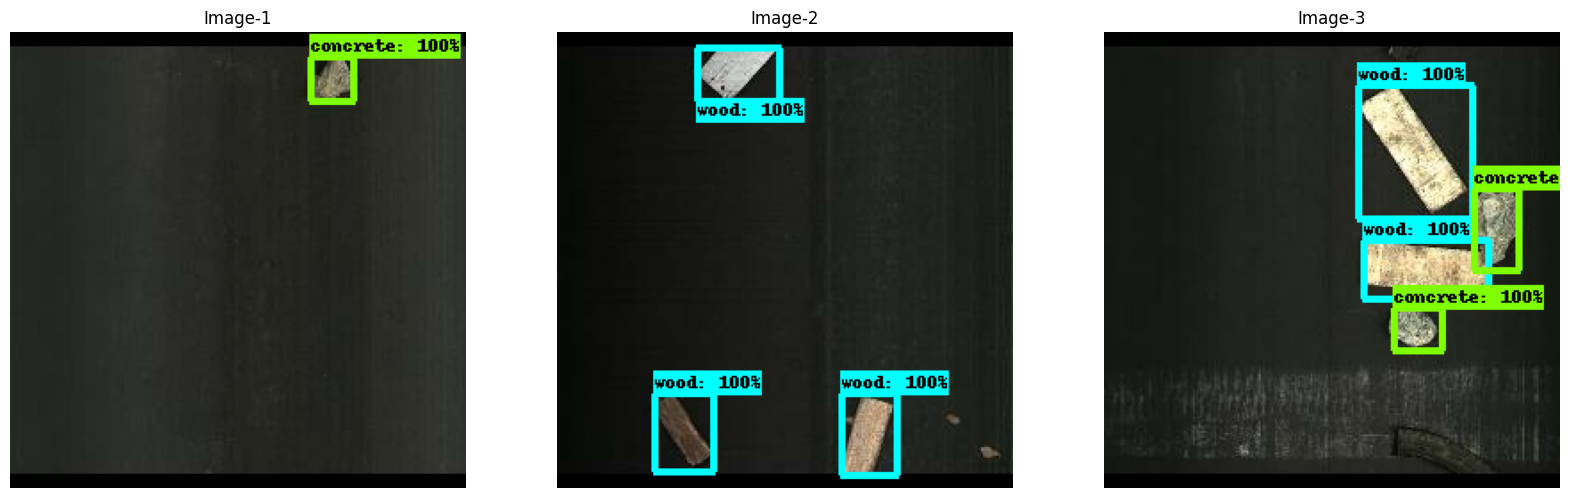

In [ ]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

## Train and evaluate.

We follow the COCO challenge tradition to evaluate the accuracy of object detection based on mAP(mean Average Precision). Please check [here](https://cocodataset.org/#detection-eval) for detail explanation of how evaluation metrics for detection task is done.

**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted bounding box and ground truth bounding box.

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

print(eval_logs)

restoring or initializing model...
train | step:      0 | training until step 100...
train | step:    100 | steps/sec:    0.1 | output: 
    {'box_loss': 0.015436334,
     'cls_loss': 0.8250625,
     'learning_rate': 0.009854709,
     'model_loss': 1.5968786,
     'total_loss': 2.9178648,
     'training_loss': 2.9178648}
saved checkpoint to ./trained_model/ckpt-100.
 eval | step:    100 | running 100 steps of evaluation...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium 

## Load logs in tensorboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './trained_model/'

<IPython.core.display.Javascript object>

## Saving and exporting the trained model.

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

## Inference from trained model

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### Visualize test data.

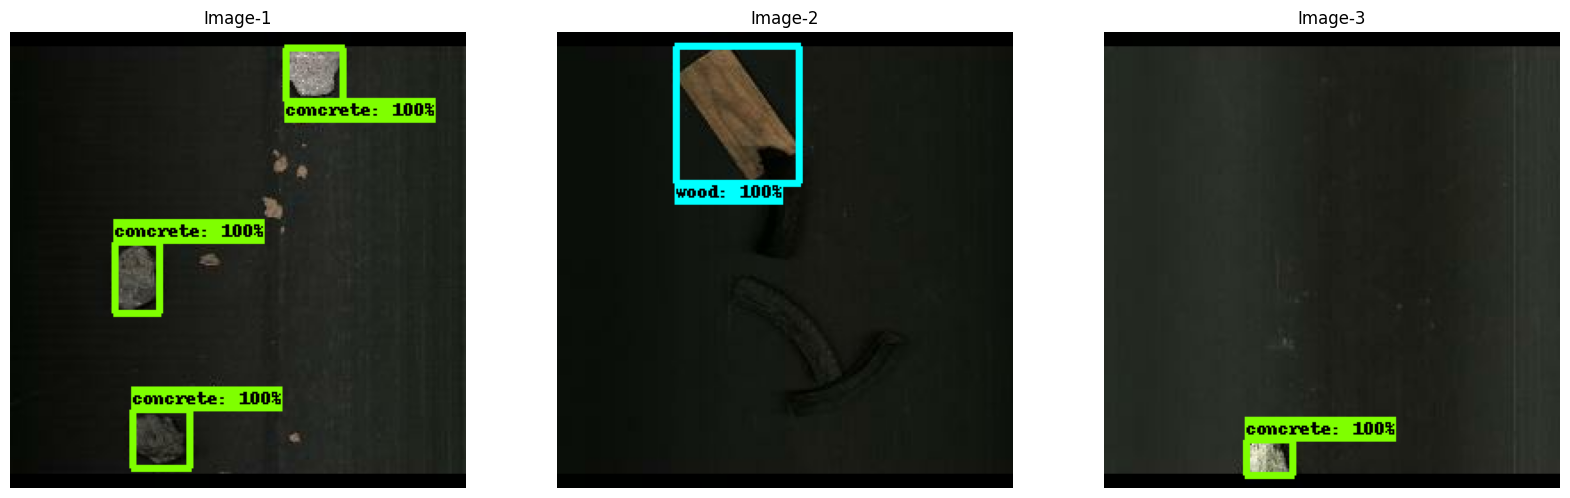

In [ ]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    './bccd_coco_tfrecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

### Importing SavedModel.

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### Visualize predictions.

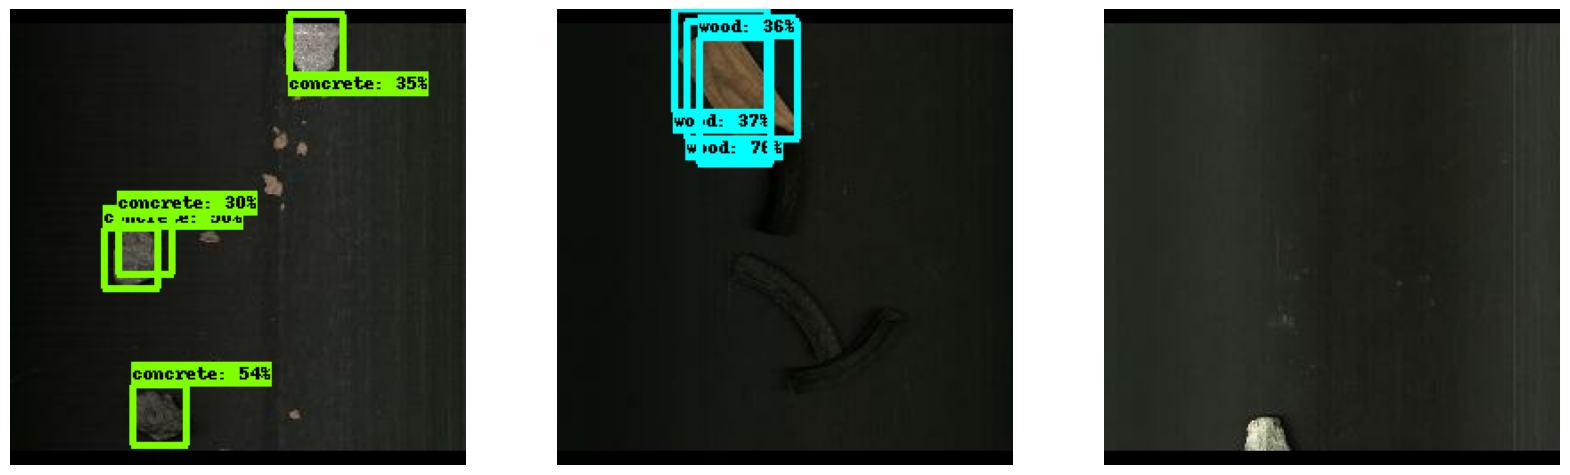

In [ ]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.30 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()

# Saving Model.zip

In [ ]:
!zip -r {model_name}.zip /content/{model_name}

In [ ]:
print("AP: " + str(round(eval_logs['AP']*100, 2)))
print("AP50: " + str(round(eval_logs['AP50']*100, 2)))
print("AP75: " + str(round(eval_logs['AP75']*100, 2)))

AP: 19.83
AP50: 53.36
AP75: 6.16


In [ ]:
print(eval_logs)